In [1]:
using JuMP, Clp, Plots

In [2]:
N = 1
d = collect(60:N:150)
p = (1/size(d,1))*ones(size(d,1));

In [3]:
function Q(x,ξ)
    m = Model(Clp.Optimizer)
    set_optimizer_attribute(m, "LogLevel",0)
    @variables(m, 
    begin
        y ≥ 0
        w ≥ 0
    end)

    @constraints(m,
    begin
        y ≤ ξ
        aux, y + w ≤ x
    end)

    @objective(m, Min, -25 * y - 5 * w)
    optimize!(m)
    return objective_value(m), shadow_price(aux)
end

Q (generic function with 1 method)

In [4]:
master = Model(Clp.Optimizer)
set_optimizer_attribute(master, "LogLevel",0)
@variable(master,x>=0)
@variable(master,α)
@constraint(master, α >= -9999)
@constraint(master, x<=150)
@objective(master, Min, 10*x + α)
optimize!(master);

iterator = 1
Q̂i_list = []
πi_list = []
x̂i_list = []
LB_list = []
UB_list = []

while true
    LB = objective_value(master)
    x̂i = value(x)
    append!(x̂i_list, x̂i)
    
    slave_Q̄i_list = []
    slave_πi_list = []
    for ξ in d
        q̂, pî = Q(x̂i,ξ)
        append!(slave_Q̄i_list, q̂)
        append!(slave_πi_list, pî)
    end

    Q̂i = sum(slave_Q̄i_list)/size(slave_Q̄i_list,1)
    πi = sum(slave_πi_list)/size(slave_πi_list,1)


    l_i = x-> Q̂i + πi*(x-x̂i)
    append!(Q̂i_list, Q̂i)
    append!(πi_list, πi)
    
    UB = 10*x̂i +sum(p[s]*Q(x̂i,d[s])[1] for s = 1:size(d,1))
    append!(LB_list, LB)
    append!(UB_list, UB)
        
    if trunc(LB, digits=5) == trunc(UB, digits=5)
        println("**SOLUTION FOUND**")
        println( "Iteration $(iterator): x̂$(iterator): $(x̂i) | Lower Bound: $(LB) & Uper Bound: $(UB)")
        println("===========")
        break
    else
        println( "Iteration $(iterator): x̂$(iterator): $(x̂i) | Lower Bound: $(LB) & Uper Bound: $(UB)")
        println("===========")
    end  
    @constraint(master, α >= l_i(x))
    optimize!(master);

    
    iterator += 1
end

Iteration 1: x̂1: 0.0 | Lower Bound: -9999.0 & Uper Bound: 0.0
Iteration 2: x̂2: 150.0 | Lower Bound: -2250.0 & Uper Bound: -1349.9999999999995
Iteration 3: x̂3: 105.00000000000003 | Lower Bound: -1574.9999999999998 & Uper Bound: -1347.527472527471
Iteration 4: x̂4: 128.00000000000006 | Lower Bound: -1460.0 & Uper Bound: -1404.3956043956023
Iteration 5: x̂5: 116.99999999999999 | Lower Bound: -1406.2087912087907 & Uper Bound: -1391.7032967032994
Iteration 6: x̂6: 122.99999999999966 | Lower Bound: -1405.2197802197804 & Uper Bound: -1401.923076923075
Iteration 7: x̂7: 125.99999999999653 | Lower Bound: -1404.7252747252746 & Uper Bound: -1404.0659340659358
Iteration 8: x̂8: 127.49999999999955 | Lower Bound: -1404.4780219780218 & Uper Bound: -1404.3681318681347
**SOLUTION FOUND**
Iteration 9: x̂9: 127.99999999998177 | Lower Bound: -1404.3956043956068 & Uper Bound: -1404.3956043956073


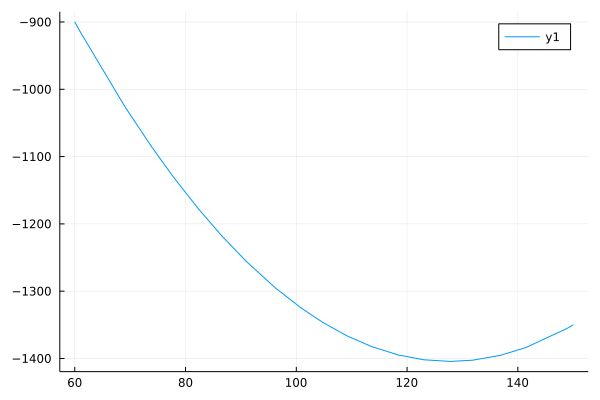

Function f(x) evaluated in range [60:150]


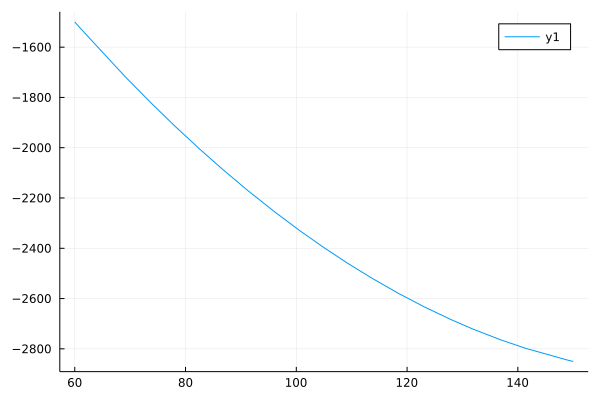

Function q(x) evaluated in range [60:150]



(process:1672): GLib-GIO-WARNING **: 01:42:57.306: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


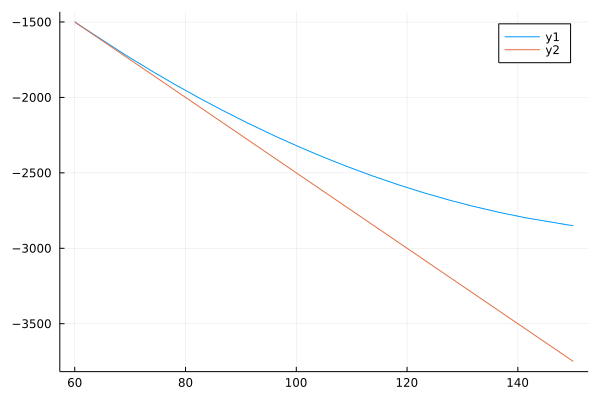

Iteration 1: x̂1: 0.0 | Lower Bound: -9999.0 & Uper Bound: 0.0

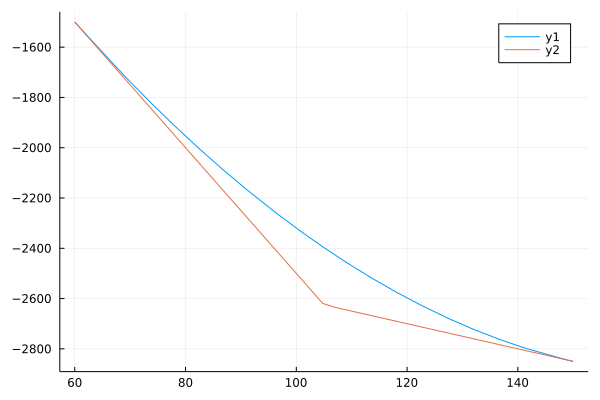


Iteration 2: x̂2: 150.0 | Lower Bound: -2250.0 & Uper Bound: -1349.9999999999995


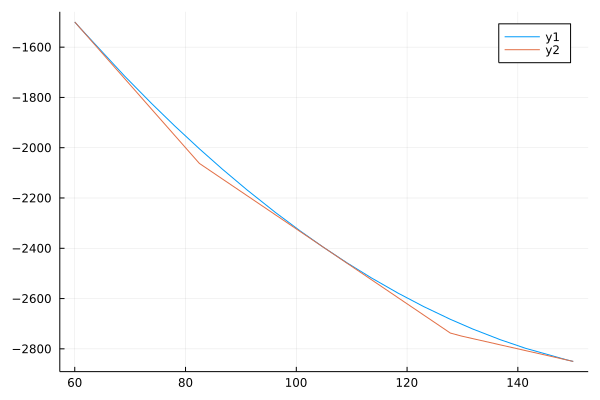

Iteration 3: x̂3: 105.00000000000003 | Lower Bound: -1574.9999999999998 & Uper Bound: -1347.527472527471

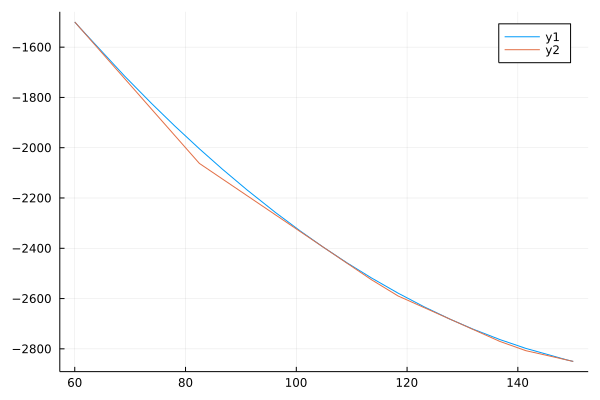


Iteration 4: x̂4: 128.00000000000006 | Lower Bound: -1460.0 & Uper Bound: -1404.3956043956023

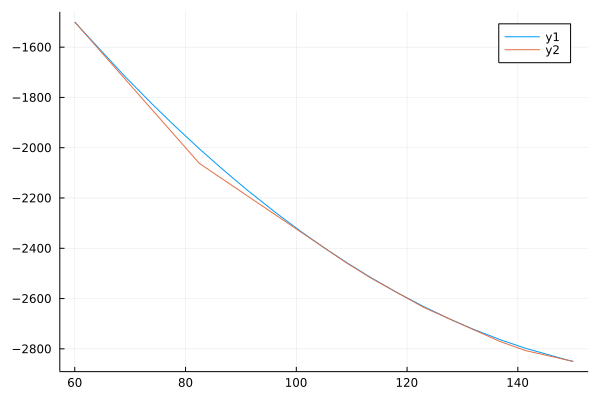


Iteration 5: x̂5: 116.99999999999999 | Lower Bound: -1406.2087912087907 & Uper Bound: -1391.7032967032994

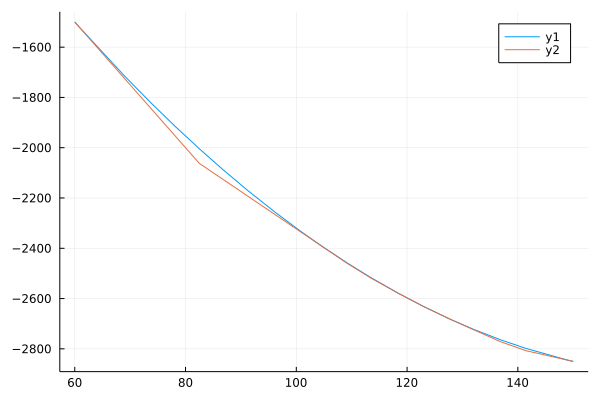


Iteration 6: x̂6: 122.99999999999966 | Lower Bound: -1405.2197802197804 & Uper Bound: -1401.923076923075

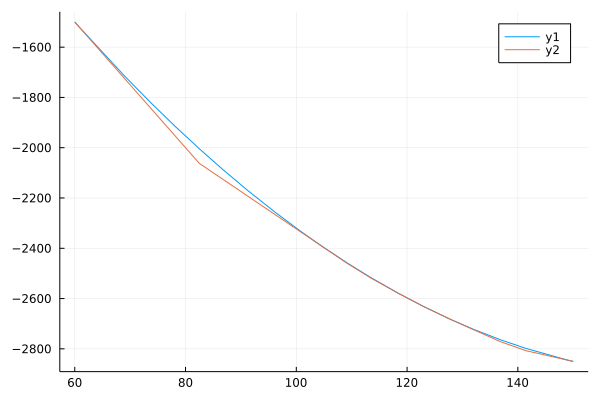


Iteration 7: x̂7: 125.99999999999653 | Lower Bound: -1404.7252747252746 & Uper Bound: -1404.0659340659358

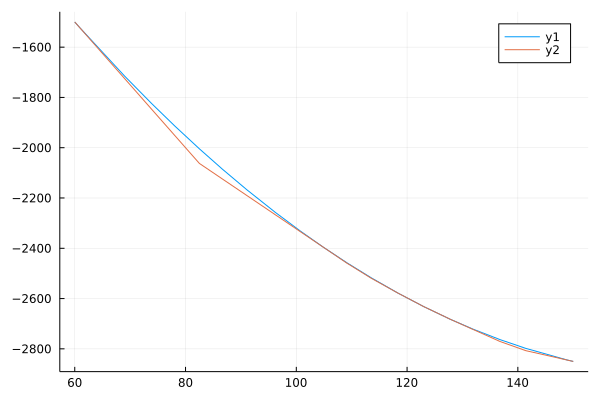


Iteration 8: x̂8: 127.49999999999955 | Lower Bound: -1404.4780219780218 & Uper Bound: -1404.3681318681347

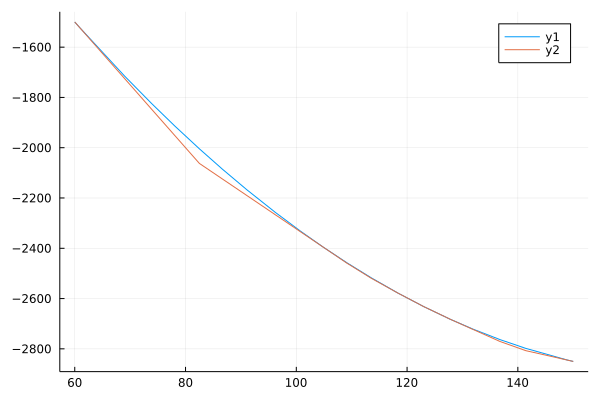


Iteration 9: x̂9: 127.99999999998177 | Lower Bound: -1404.3956043956068 & Uper Bound: -1404.3956043956073


In [5]:
l = [x->Q̂i_list[i] + πi_list[i]*(x-x̂i_list[i]) for i in 1:size(Q̂i_list,1)]
q̂_ = [x-> max(-9999,maximum(l[a](x) for a in 1:i)) for i in 1:size(Q̂i_list,1)]

println( "Function f(x) evaluated in range [60:150]")
println("===============================================================================================================")
f(x) = 10*x + sum(p[s]*Q(x,d[s])[1] for s = 1:size(d,1))
display(plot(f, 60,150))

println( "Function q(x) evaluated in range [60:150]")
println("===============================================================================================================")
q(x) = sum(p[s]*Q(x,d[s])[1] for s = 1:size(d,1))
display(plot(q, 60,150))


for i in 1:size(q̂_,1)
    plt = plot(q, 60,150)
    plot!(q̂_[i], 60, 150)
    println( "Iteration $(i): x̂$(i): $(x̂i_list[i]) | Lower Bound: $(LB_list[i]) & Uper Bound: $(UB_list[i])")
    println("===============================================================================================================")
    display(plt)
end